# HACKtheMACHINE 2021 | Track 2: Data Science, Detective Bot 

# Not the Coronavirus

#### Roland Chin, Lino Valdavinos

The following data dictionary describes the columns or fields of the data set and a description of the objects. This information with more detail can also be found in the `EMBER` documentation of the `features.py` file at: https://github.com/elastic/ember/blob/master/ember/features.py 

| Field Name | Description | 
|------------|-------------|
| sha256 | The Secure Hash Algorithm (SHA) is a cryptographic hash function like a signature or fingerprints for a data set. Even if one symbol is changed the algorithm will produce a different hash value. The SHA256 algorithm generates a fixed size 256-bit (32-byte) hash. The SHA256 algorithm is used to ensure you acquire the same data as the original. For exmaple, if you download something you can check if the data has not changed (due to network errors or malware injection) by comparing the hashes of your file and the original.|
| histogram | Byte histogram (count + non-normalized) over the entire binary file. The byte histogram contains 256 integer values and represent the counts of each byte value within the value. When generating model features the byte histgoram is normalized to a distribution, since file size is represented as a feature in the general file information. | 
| byteentropy | 2D byte/entropy histogram based loosely on (Saxe and Berlin, 2015). This roughly approximates the joint probability of byte value and local entropy. See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info. The byte entropy histogram approximates the joint distriubtion p(H, X) of entropy H and byte value X. By computing the scalar entropy H for a fixed-length window and pairing it with each byte occurrence within the window. This is repeated as the window slides across the input bytes. |
| strings | Contains simple statistics about printable strings of the following: <ul><li>`numstrings`: number of strings <li> `avlength`: average length of strings <li>`printabledist`: histogram of the printable characters within those strings <li>`printables`: distinct information from byte histogram information from the byte histogram information since its derived only from strings containing at least 5 consecutive printable characters <li>`entropy`: entropy of characters across all printable strings <li>`paths` number of strings that begin with **C:** (case insensitive) that may indicate a path <li>`urls`: the number of occurences of **http://** or **https://** (case insensitive) that may indicate a URL <li>`registry`: number of occurrences of HKEY that may indicate a registry key, <li>`MZ`: number of occurrences of the short string MZ |
| general | Provides general file information. 0/1 indicates a binary output <ul><li>`size`: length of bytes <li>`vsize`: virtual size <li>`has_debug`: 0/1  <li>`exports`: 0/1 <li>`imports`: 0/1 <li>`has_relocations`: 0/1  <li>`has_resources`: 0/1 <li>`has_signature`: 0/1 <li>`has_tls`: 0/1 <li>`symbols`: 0/1 |
| header | Provides header file information on machine, architecture, OS, link and other information: <ul><li> `coeff`: [ `timestamp`, `machine`,`characteristics` ] <li> `optional`: [`subsystem`, `dll_characteristics`, `magic`, `major_image_version`, `minor_linker_version`, `major_operating_system_version`, `minor_operating_system_version`, `major_subsystem_version`, `minor_subsystem_version`, `sizeof_code`, `sizeof_headers`, `sizeof_heap_commit`]
| section | Information about section names, sizes and entropy. Uses hashing trick to summarize all this section into a feature vector. <ul><li> `imports`: [`KERNEL32.dll` : [`GetTickCount`] | 
| imports | Information about imported libraries and functions from the import address table. Note that the total number of imported functions is contained in GeneralFileInfo. |
| exports | Information about exported functions. Note that the total number of exported functions is contained in GeneralFileInfo.|
| datadirectories | Extracts size and virtual address of the first 15 data dictectories. |
| label / category | Class label indicating benign `0` or malicious `1`|

## Load Libraries

In [1]:
import numpy as np #data manipulation
import pandas as pd #data manipulation
import sklearn as sk #modeling & metrics
import seaborn as sns #visualizations
import scipy as stats #visualizations
from matplotlib import pyplot as plt #visualizations

#imputation, scaling, metrics
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import r2_score, classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

#outlier classification
from sklearn.ensemble import IsolationForest

import xgboost as xgb #xgb model
import lightgbm as lgb
import hyperopt #hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap #shap plot

import pickle 
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/elastic/ember.git #only need to run this once

This is the wrapper class that transforms the raw excel file into numpy arrays so it becomes the same output as EMBER's code.

In [3]:
import Ember_Wrapper

These 2 modules are new for challenge 2.

## Requirements

The requirements file is this output copy pasted into a txt file.

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.21.2
pandas==1.3.4
sklearn==1.0.1
seaborn==0.11.2
scipy==1.6.0
xgboost==1.5.0
lightgbm==3.2.1
hyperopt==0.2.5
shap==0.40.0


## Load Data

In [5]:
# Flattened EMBER Feature set
# Easier to feed into ML models right away
# df1 = pd.read_excel("flatten_train.xlsx")

Use pickling so you don't have to read in the Excel file every time to resume progress.

In [6]:
# pd.to_pickle(df1, "./data.pkl")

Initially df1, the flattened data, was utilized. Until the wrapper class was created in order to use more of the features from the raw data.

In [7]:
# df1 = pd.read_pickle("./data.pkl")

In [8]:
df2 = pd.read_excel("./Data/raw_train.xlsx")

Check number of malware entries.

In [9]:
# sum(df1['category'])

In [10]:
# df1.shape

In [11]:
# 900/18000

5%, super imbalanced classes. XGBoost has a built in scale_pos_weight argument that could help with this.

We tried it using the full dataset consisting of 18000 rows with scale_pos_weight set to 19 (17100/900) but undersampling which yielded only 1800 rows performed better.

## EDA

### Visualizations Team here:
#### Main idea: plot distributions of specific features to compare their usefulness in distinguishing between the malware and benign entries.

In [12]:
# df1.head(5)

In [13]:
# list(df1)

In [14]:
# malware = df1[df1['category'] == 1]
# not_malware = df1[df1['category'] == 0]

In [15]:
# def dist_plotter(feature_name):
#     '''this function takes in a specific feature and compares its distribution between both classes'''
#     fig, ax = plt.subplots(2,1)
# #     ax.set(ylabel='common ylabel', title=feature_name)
#     sns.violinplot(malware[feature_name], inner="quartile", ax=ax[0], color='r')
#     sns.violinplot(not_malware[feature_name], inner="quartile", ax=ax[1], color='r')

In [16]:
# dist_plotter('byteentropy_211')

*this was preliminary, more EDA to be included in the final powerpoint was performed by other members of the team.

## Undersampling

Since only 5% of entries are malware, we want a similar 50/50 split between malware and not malware. SMOTE was also utilized, with comparable results.

In [17]:
majority = df2[df2.category==0] # Majority class
minority = df2[df2.category==1] # Minority class

In [18]:
majority_undersampled = resample(majority, replace=False, n_samples=5400) # Randomly selects 900 records from majority to match minority class size
# New downsampled dataset
df_undersampled = pd.concat([majority_undersampled, minority])  # Minority class + sample of 900 from majority
df_undersampled.category.value_counts()

0    5400
1     900
Name: category, dtype: int64

In [19]:
#4500 900 (6 imbalance) = 71% F1 test, 80% F1 total raw
#5400 900 (7 imbalance) =  F1 test, F1 total raw

In [20]:
X, y = Ember_Wrapper.create_vectorize_features(df_undersampled)

The ember wrapper creates similar vectoriized features as the output of the EMBER code, creating new X and y numpy arrays.

In [21]:
# X = np.load('./X_data.npy')
# y = np.load('./y_data.npy')
# print('X.shape', X.shape)
# print('%Malware:', sum(y) / len(y))

In [22]:
# df = df_undersampled #make it a new df

In [23]:
# X = df.drop('category', axis=1) #X is everything but the 'category' col

In [24]:
# y = df['category'] #y is just the target column

In [25]:
# X = X._get_numeric_data() #drop all nonnumeric ones (for now?)

In [26]:
# print(X.shape, y.shape) #sanity check arrays

## Feature Selection with ANOVA

First perform a standard train-test split.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #train test split 80/20

Ideally should select features after heatmaps/correlation plots/distributions etc but skipped for now. Due to the speed of XGBoost combined with our limited amount of time, we decided to simply utilize all features in our model.

PCA can also be performed here.

In [28]:
X_train.shape

(5040, 2381)

In [29]:
X_test.shape

(1260, 2381)

In [30]:
y_train.shape

(5040,)

In [31]:
y_test.shape

(1260,)

In [32]:
# fs = SelectKBest(score_func=f_classif, k=600) #THIS K IS HOW MANY FEATURES YOU WANT
# fs.fit(X_train, y_train)
# mask = fs.get_support()
# new_features = X_train.columns[mask]

This is based on univariate feature selection, comparing ANOVA F-values (not to be confused with the F1 model performance metric). Chi-square can also be used in place of ANOVA.

In [33]:
# X_train_fs = X_train[new_features]
# X_test_fs = X_test[new_features]

We initially utilized the fs (feature selected) versions of our X_train and X_test, but that was before utilizing our ember wrapper.

In [34]:
X_train_fs = X_train
X_test_fs = X_test

In [35]:
print(X_train_fs.shape, X_test_fs.shape)

(5040, 2381) (1260, 2381)


In [36]:
print(y_train.shape, y_test.shape)

(5040,) (1260,)


## Modeling

This function basically fits a specified model and outputs it's f1_score as well as ROC curve, can add more graphs/plots to it as well.

In [37]:
# def modeler(model):
#     model.fit(X_train_fs, y_train) #fit specified model
#     y_pred = model.predict(X_test_fs) #predict on test set
#     f1 = f1_score(y_test, y_pred) #get f1 score
#     print('F1 Score:', f1)
#     print(metrics.confusion_matrix(y_test, y_pred))
    
#     print('roc_auc score:',roc_auc_score(y_test, y_pred))
#     print('precision:', precision_score(y_test, y_pred))
#     print('recall:',recall_score(y_test, y_pred))
    
#     #this plots the ROC curve, play around iwth it
#     from sklearn.metrics import roc_curve, auc
#     fpr, tpr, thresholds = roc_curve(y_pred, y_test)
#     roc_auc = auc(fpr, tpr)

#     plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic')
#     plt.legend(loc="lower right")
#     plt.show()

In [38]:
# lr = LogisticRegression()
# modeler(lr)

In [39]:
# lgbm = lgb.LGBMClassifier()
# modeler(lgbm)

In [40]:
# xgbc = xgb.XGBClassifier(eval_metric='logloss')
# modeler(xgbc)

In [41]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# modeler(rf)

In [42]:
# from sklearn.svm import SVC
# svm = SVC()
# modeler(svm)

In [43]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()
# modeler(knn)

In [44]:
# from sklearn import tree
# dt = tree.DecisionTreeClassifier()
# modeler(dt)

The best models before hyperparameter optimization seem to be LGBM and XGB. Ideal ROC graph looks hugs the top left corner.

## Bayesian Hyperparameter Optimization

Hyperopt will be used to implement Bayesian Hyperparmater Optimization, which is far more efficient than random-grid search.

(Scaling/normalizing is not needed for gradient boosted decision trees, thus was not performed)

In [45]:
#hyperparameter domain to search over
hyperparam_space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 10, 1, dtype=int)), #larger values = overfitting
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, 1, dtype=int)), #larger values = overfitting
    'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01) #aka eta = step size shrinkage to prevent overfitting
#     'gamma': hp.quniform('gamma', 0, 1, 0.05) #gamma: min loss reduction to partition leaf nodes (for overfitting)
#     'min_child_weight': hp.quniform('min_child_weight', 1, 8, 0.5),
#     'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
}

In [46]:
# def xgb_score(params): #function to train and test different hyperparams
#     model = xgb.XGBClassifier(**params, eval_metric='logloss', scale_pos_weight=7)
#     model.fit(X_train_fs, y_train, early_stopping_rounds=20,
#              eval_set=[(X_train_fs, y_train), (X_test_fs, y_test)])
#     score = -cross_val_score(model, X_train_fs, y_train, cv=10, scoring='roc_auc').mean()
#     print(score)
#     return {'loss': score, 'status': STATUS_OK}
            
# def xgb_optimize(trials, space): #fmin is the main library function that minimizes the 'loss function' xgb_score
#     best = fmin(xgb_score, space, algo=tpe.suggest, max_evals=1)
#     return best
            
# trials = Trials() #database that store completed hyperparameters and score
# best_xgb_params = xgb_optimize(trials, hyperparam_space) #calls fmin

In [47]:
# best_xgb_params = {'learning_rate': 0.31, 'max_depth': 6, 'n_estimators': 31} #undersampling 4500 benign scale_pos_weight = 6
# best_xgb_params = {'learning_rate': 0.59, 'max_depth': 8, 'n_estimators': 362} #undersampling 5400 benign scale_pos_weight = 7

best_xgb_params = {'learning_rate': 0.59, 'max_depth': 8, 'n_estimators': 362}

The above are our best hyperparameters, with the average 10 fold cross validation being minimized.

## Tuned Model

In [48]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

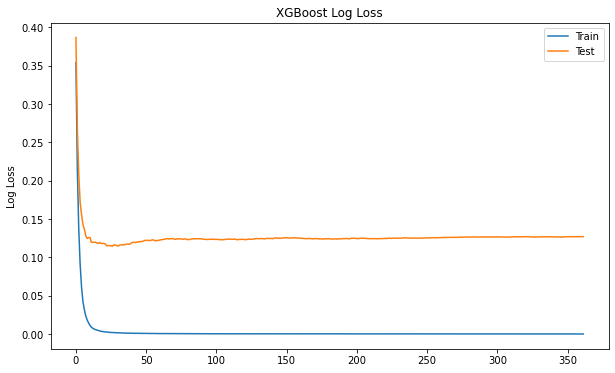

In [49]:
xgb_model = xgb.XGBClassifier(**best_xgb_params, eval_metric='logloss', scale_pos_weight=6) #utilize these best params
eval_set = [(X_train_fs, y_train), (X_test_fs, y_test)] #have an eval set to keep track of learning rate over time
xgb_model.fit(X_train_fs, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False) #fit the best model

results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
    
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

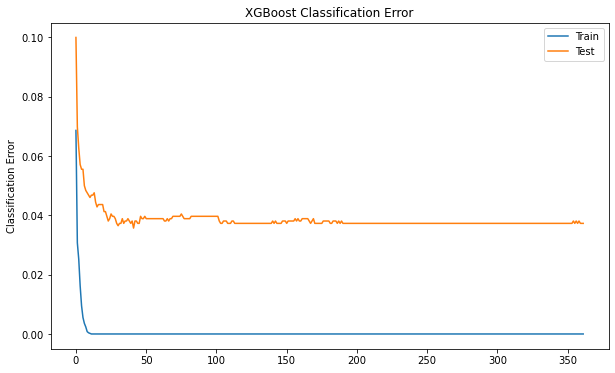

In [50]:
#similar as above, but with classification error now
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
    
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

## Save Model

In [51]:
# xgb_model.save_model("xgb_model.txt")
pickle.dump(xgb_model, open('xgb_model.pkl', "wb"))


## Testing on Output 

First load in the saved model.

In [52]:
# saved_model = xgb.Booster()
# saved_model.load_model("xgb_model.txt")

saved_model = pickle.load(open('xgb_model.pkl', "rb"))
# saved_model = xgb_model

XGBoost for some reason requires the input to be in a DMatrix format now, despite not needing the same format during training.

In [53]:
# X_test_D = xgb.DMatrix(X_test_fs)

The threshold score was calculated in a below cell, using code from the EMBER repository.

We decided to use a threshold that gave a lower F1 score in order to minimize our false negative rate, as this would mean allowing in malware which is dangerous.

In [54]:
# 0.0872

In [55]:
y_pred = saved_model.predict(X_test_fs)

In [56]:
def our_threshold(y_true, y_pred):
    thresh = 0.0
    best_t = 0.0
    min_f1 = 0.0
    while thresh < 1.0:
        thresh += 0.001
        f1 = f1_score(y_true, (y_pred > thresh))
        if f1 > min_f1:
            min_f1 = f1
            best_t = thresh
    return best_t, min_f1

In [57]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [58]:
# T, f1 = our_threshold(y_test, real_pred)
# T

NameError: name 'real_pred' is not defined

In [ ]:
# y_pred = saved_model.predict(X_test_D)
# f1=f1_score(y_test, (y_pred > 0.0872))
# print('F1 Score:', f1)
# print(confusion_matrix(y_test, (y_pred > 0.0872)))
# print(classification_report(y_test, (y_pred > 0.0872)))

In [60]:
y_pred = saved_model.predict(X_test_fs)
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1 Score: 0.8645533141210374
[[1063   21]
 [  26  150]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1084
           1       0.88      0.85      0.86       176

    accuracy                           0.96      1260
   macro avg       0.93      0.92      0.92      1260
weighted avg       0.96      0.96      0.96      1260



As we can see, the false positive rate is approximately 5%, while the false negative rate is only 0.56%.

In [ ]:
cf_matrix = confusion_matrix(y_test, (y_pred > 0.0872))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix XGB\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Further confirmation from the ROC curve below. 

In [ ]:
#this plots the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGB')
plt.legend(loc="lower right")
plt.show()

This is the code used to calculate the threshold at various false positive rate targets.

In [ ]:
# def get_fpr(y_true, y_pred):
#     nbenign = (y_true == 0).sum()
#     nfalse = (y_pred[y_true == 0] == 1).sum()
#     return nfalse / float(nbenign)


# def find_threshold(y_true, y_pred, fpr_target):
#     thresh = 0.0
#     fpr = get_fpr(y_true, y_pred > thresh)
#     while fpr > fpr_target and thresh < 1.0:
#         thresh += 0.0001
#         fpr = get_fpr(y_true, y_pred > thresh)
#     return thresh, fpr

# # testdf = emberdf[emberdf["subset"] == "test"]
# print("ROC AUC:", roc_auc_score(y_test, y_pred))
# print()


# threshold, fpr = find_threshold(y_test, y_pred, 0.1)
# fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
# print("XGB Model Performance at 10% FPR:")
# print("Threshold: {:.4f}".format(threshold))
# print("False Positive Rate: {:.3f}%".format(fpr * 100))
# print("False Negative Rate: {:.3f}%".format(fnr * 100))
# print("Detection Rate: {}%".format(100 - fnr * 100))
# print()

# threshold, fpr = find_threshold(y_test, y_pred, 0.01)
# fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
# print("XGB Model Performance at 1% FPR:")
# print("Threshold: {:.4f}".format(threshold))
# print("False Positive Rate: {:.3f}%".format(fpr * 100))
# print("False Negative Rate: {:.3f}%".format(fnr * 100))
# print("Detection Rate: {}%".format(100 - fnr * 100))
# print()

# threshold, fpr = find_threshold(y_test, y_pred, 0.001)
# fnr = (y_pred[y_test == 1] < threshold).sum() / float((y_test == 1).sum())
# print("XGB Model Performance at 0.1% FPR:")
# print("Threshold: {:.4f}".format(threshold))
# print("False Positive Rate: {:.3f}%".format(fpr * 100))
# print("False Negative Rate: {:.3f}%".format(fnr * 100))
# print("Detection Rate: {}%".format(100 - fnr * 100))

## Feature Evaluation

Both SHAP values and XGB's built in feature importance can be utilized to further inspect how specific features impacted predictions.

Currently the features are referenced by number due to how our ember wrapper flattens them, but this can be later revised to reference their actual names.

In [ ]:
# shap_values = shap.TreeExplainer(saved_model).shap_values(X_test_fs)
# shap.summary_plot(shap_values, X_test_fs)

In [ ]:
# xgb.plot_importance(saved_model, importance_type='cover', max_num_features=20)
# plt.figure(figsize=(25, 12))
# plt.show()

## Conclusions

## Visualizations should include the above ROC plots, SHAP plots, as well as the built in feature importance plots.